**Importing Libraries**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time


**Creating the Maze Environment**


The code below sets up a simple maze with walls, a starting point (S), and a goal point (G). The maze is set up on a grid where each cell is either a 0 or 1, with 0 representing a black empty space and 1 representing a white wall. For your science project, you can use the sample maze we have provided, or change the code to make your own.



In [3]:
class Maze:
    def __init__(self, maze, start_position, goal_position):
        # Initialize Maze object with the provided maze, start_position, and goal position
        self.maze = maze
        self.maze_height = maze_layout.shape[0] # Get the height of the maze (number of rows)
        self.maze_width = maze_layout.shape[1]  # Get the width of the maze (number of columns)
        self.start_position = start_position    # Set the start position in the maze as a tuple (x, y)
        self.goal_position = goal_position      # Set the goal position in the maze as a tuple (x, y)

    def show_maze(self):
        # Visualize the maze using Matplotlib
        plt.figure(figsize=(5,5))

        # Display the maze as an image in grayscale ('gray' colormap)
        plt.imshow(self.maze, cmap='gray')

        # Add start and goal positions as 'S' and 'G'
        plt.text(self.start_position[0], self.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
        plt.text(self.goal_position[0], self.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)

        # Remove ticks and labels from the axes
        plt.xticks([]), plt.yticks([])

        # Show the plot
        plt.show()



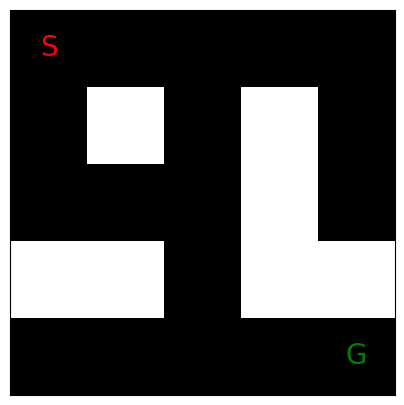

In [4]:
# Create any maze layout you'd like, here's an example
maze_layout = np.array([
    [0, 0, 0, 0, 0],
    [0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0],
    [1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0]
])

# Create an instance of the maze and set the starting and ending positions
maze = Maze(maze_layout, (0, 0), (4, 4))
# Visualize the maze
maze.show_maze()

##**Implementing the Agent**

In [5]:
# Actions the agent can take: Up, Down, Left, Right. Each action is represented as a tuple of two values: (row_change, column_change)
actions = [(-1, 0), # Up: Moving one step up, reducing the row index by 1
          (1, 0),   # Down: Moving on step down, increasing the row index by 1
          (0, -1),  # Left: Moving one step to the left, reducing the column index by 1
          (0, 1)]   # Right: Moving one step to the right, increasing the column index by 1

class QLearningAgent:
    def __init__(self, maze, learning_rate=0.1, discount_factor=0.9, exploration_start=1.0, exploration_end=0.01, num_episodes=100):
        # Initialize the Q-learning agent with a Q-table containing all zeros
        # where the rows represent states, columns represent actions, and the third dimension is for each action (Up, Down, Left, Right)
        self.q_table = np.zeros((maze.maze_height, maze.maze_width, 4)) # 4 actions: Up, Down, Left, Right
        self.learning_rate = learning_rate          # Learning rate controls how much the agent updates its Q-values after each action
        self.discount_factor = discount_factor      # Discount factor determines the importance of future rewards in the agent's decisions
        self.exploration_start = exploration_start  # Exploration rate determines the likelihood of the agent taking a random action
        self.exploration_end = exploration_end
        self.num_episodes = num_episodes

    def get_exploration_rate(self, current_episode):
        # Calculate the current exploration rate using the given formula
        exploration_rate = self.exploration_start * (self.exploration_end / self.exploration_start) ** (current_episode / self.num_episodes)
        return exploration_rate

    def get_action(self, state, current_episode): # State is tuple representing where agent is in maze (x, y)
        exploration_rate = self.get_exploration_rate(current_episode)
        # Select an action for the given state either randomly (exploration) or using the Q-table (exploitation)
        if np.random.rand() < exploration_rate:
            return np.random.randint(4) # Choose a random action (index 0 to 3, representing Up, Down, Left, Right)
        else:
            return np.argmax(self.q_table[state]) # Choose the action with the highest Q-value for the given state

    def update_q_table(self, state, action, next_state, reward):
        # Find the best next action by selecting the action that maximizes the Q-value for the next state
        best_next_action = np.argmax(self.q_table[next_state])

        # Get the current Q-value for the current state and action
        current_q_value = self.q_table[state][action]

        # Q-value update using Q-learning formula
        new_q_value = current_q_value + self.learning_rate * (reward + self.discount_factor * self.q_table[next_state][best_next_action] - current_q_value)

        # Update the Q-table with the new Q-value for the current state and action
        self.q_table[state][action] = new_q_value



##**Defining the Reward System**

In [6]:
goal_reward = 100
wall_penalty = -10
step_penalty = -1

## **Testing the Agent**

The code below tests how well the agent navigates the maze. It reports the total number of steps the agent took to get through the maze as well as the total reward the agent accumulated.

In [7]:
# This function simulates the agent's movements in the maze for a single episode.

def finish_episode(agent, maze, current_episode, train=True):
    # Initialize the agent's current state to the maze's start position
    current_state = maze.start_position
    is_done = False
    episode_reward = 0
    episode_step = 0
    path = [current_state]

    # Continue until the episode is done
    while not is_done:
        # Get the agent's action for the current state using its Q-table
        action = agent.get_action(current_state, current_episode)

        # Compute the next state based on the chosen action
        next_state = (current_state[0] + actions[action][0], current_state[1] + actions[action][1])

        # Check if the next state is out of bounds or hitting a wall
        if next_state[0] < 0 or next_state[0] >= maze.maze_height or next_state[1] < 0 or next_state[1] >= maze.maze_width or maze.maze[next_state[1]][next_state[0]] == 1:
            reward = wall_penalty
            next_state = current_state
        # Check if the agent reached the goal:
        elif next_state == (maze.goal_position):
            path.append(current_state)
            reward = goal_reward
            is_done = True
        # The agent takes a step but hasn't reached the goal yet
        else:
            path.append(current_state)
            reward = step_penalty

        # Update the cumulative reward and step count for the episode
        episode_reward += reward
        episode_step += 1

        # Update the agent's Q-table if training is enabled
        if train == True:
            agent.update_q_table(current_state, action, next_state, reward)

        # Move to the next state for the next iteration
        current_state = next_state

    # Return the cumulative episode reward, total number of steps, and the agent's path during the simulation
    return episode_reward, episode_step, path


**Test the Agent without Train**

Learned Path:
(0, 0)-> (0, 0)-> (1, 0)-> (0, 0)-> (0, 1)-> (0, 0)-> (1, 0)-> (2, 0)-> (2, 1)-> (2, 0)-> (2, 1)-> (2, 0)-> (3, 0)-> (4, 0)-> (4, 1)-> (4, 0)-> (3, 0)-> (4, 0)-> (3, 0)-> (2, 0)-> (2, 1)-> (2, 2)-> (2, 1)-> (2, 0)-> (3, 0)-> (4, 0)-> (4, 1)-> (4, 0)-> (4, 1)-> (4, 2)-> (4, 1)-> (4, 2)-> (4, 1)-> (4, 2)-> (4, 1)-> (4, 0)-> (3, 0)-> (4, 0)-> (4, 1)-> (4, 2)-> (4, 1)-> (4, 0)-> (4, 1)-> (4, 0)-> (4, 1)-> (4, 0)-> (3, 0)-> (2, 0)-> (1, 0)-> (0, 0)-> (0, 1)-> (0, 0)-> (1, 0)-> (0, 0)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 2)-> (0, 1)-> (0, 0)-> (1, 0)-> (0, 0)-> (0, 1)-> (0, 2)-> (1, 2)-> (2, 2)-> (1, 2)-> (0, 2)-> (1, 2)-> (0, 2)-> (0, 1)-> (0, 0)-> (1, 0)-> (2, 0)-> (3, 0)-> (2, 0)-> (1, 0)-> (2, 0)-> (1, 0)-> (0, 0)-> (0, 1)-> (0, 0)-> (0, 1)-> (0, 2)-> (1, 2)-> (2, 2)-> (2, 3)-> (2, 2)-> (1, 2)-> (2, 2)-> (2, 1)-> (2, 2)-> (2, 3)-> (2, 4)-> (1, 4)-> (2, 4)-> (3, 4)-> (2, 4)-> (2, 3)-> (2, 4)-> (2, 3)-> (2, 4)-> (3, 4)-> (2, 4)-> (2, 3)-> (2, 2)-> (2, 1)-> (2, 2)-> (2, 3)-> (2, 2

<Figure size 640x480 with 0 Axes>

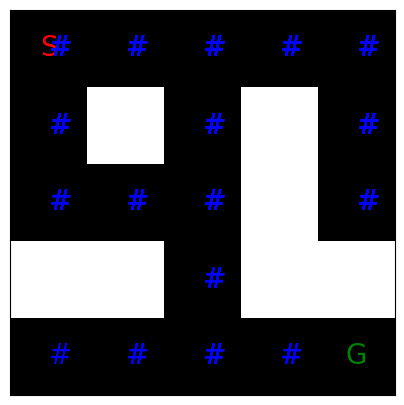

(485, -2517)

In [19]:
# This function evaluates an agent's performance in the maze. The function simulates the agent's movements in the maze,
# updating its state, accumulating the rewards, and determining the end of the episode when the agent reaches the goal position.
# The agent's learned path is then printed along with the total number of steps taken and the total reward obtained during the
# simulation. The function also visualizes the maze with the agent's path marked in blue for better visualization of the
# agent's trajectory.

def test_agent(agent, maze, num_episodes=1):
    # Simulate the agent's behavior in the maze for the specified number of episodes
    episode_reward, episode_step, path = finish_episode(agent, maze, num_episodes, train=False)

    # Print the learned path of the agent
    print("Learned Path:")
    for row, col in path:
        print(f"({row}, {col})-> ", end='')
    print("Goal!")

    print("Number of steps:", episode_step)
    print("Total reward:", episode_reward)

    # Clear the existing plot if any
    if plt.gcf().get_axes():
        plt.cla()

    # Visualize the maze using matplotlib
    plt.figure(figsize=(5,5))
    plt.imshow(maze.maze, cmap='gray')

    # Mark the start position (red 'S') and goal position (green 'G') in the maze
    plt.text(maze.start_position[0], maze.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
    plt.text(maze.goal_position[0], maze.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)

    # Mark the agent's path with blue '#' symbols
    for position in path:
        plt.text(position[0], position[1], "#", va='center', color='blue', fontsize=20)

    # Remove axis ticks and grid lines for a cleaner visualization
    plt.xticks([]), plt.yticks([])
    plt.grid(color='black', linewidth=2)
    plt.show()

    return episode_step, episode_reward

agent = QLearningAgent(maze)
# Test the agent using the test_agent function
test_agent(agent, maze)

**Test after Training**

In [21]:
def train_agent(agent, maze, num_episodes=100):
    # Lists to store the data for plotting
    episode_rewards = []
    episode_steps = []

    # Loop over the specified number of episodes
    for episode in range(num_episodes):
        episode_reward, episode_step, path = finish_episode(agent, maze, episode, train=True)

        # Store the episode's cumulative reward and the number of steps taken in their respective lists
        episode_rewards.append(episode_reward)
        episode_steps.append(episode_step)

    # Plotting the data after training is completed
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Cumulative Reward')
    plt.title('Reward per Episode')

    average_reward = sum(episode_rewards) / len(episode_rewards)
    print(f"The average reward is: {average_reward}")

    plt.subplot(1, 2, 2)
    plt.plot(episode_steps)
    plt.xlabel('Episode')
    plt.ylabel('Steps Taken')
    plt.ylim(0, 100)
    plt.title('Steps per Episode')

    average_steps = sum(episode_steps) / len(episode_steps)
    print(f"The average steps is: {average_steps}")

    plt.tight_layout()
    plt.show()



In [20]:
# This function evaluates an agent's performance in the maze. The function simulates the agent's movements in the maze,
# updating its state, accumulating the rewards, and determining the end of the episode when the agent reaches the goal position.
# The agent's learned path is then printed along with the total number of steps taken and the total reward obtained during the
# simulation. The function also visualizes the maze with the agent's path marked in blue for better visualization of the
# agent's trajectory.

def test_agent(agent, maze, num_episodes=1):
    # Simulate the agent's behavior in the maze for the specified number of episodes
    episode_reward, episode_step, path = finish_episode(agent, maze, num_episodes, train=True)

    # Print the learned path of the agent
    print("Learned Path:")
    for row, col in path:
        print(f"({row}, {col})-> ", end='')
    print("Goal!")

    print("Number of steps:", episode_step)
    print("Total reward:", episode_reward)

    # Clear the existing plot if any
    if plt.gcf().get_axes():
        plt.cla()

    # Visualize the maze using matplotlib
    plt.figure(figsize=(5,5))
    plt.imshow(maze.maze, cmap='gray')

    # Mark the start position (red 'S') and goal position (green 'G') in the maze
    plt.text(maze.start_position[0], maze.start_position[1], 'S', ha='center', va='center', color='red', fontsize=20)
    plt.text(maze.goal_position[0], maze.goal_position[1], 'G', ha='center', va='center', color='green', fontsize=20)

    # Mark the agent's path with blue '#' symbols
    for position in path:
        plt.text(position[0], position[1], "#", va='center', color='blue', fontsize=20)

    # Remove axis ticks and grid lines for a cleaner visualization
    plt.xticks([]), plt.yticks([])
    plt.grid(color='black', linewidth=2)
    plt.show()

    return episode_step, episode_reward


##**Training the Agent**

The average reward is: 36.74
The average steps is: 19.89


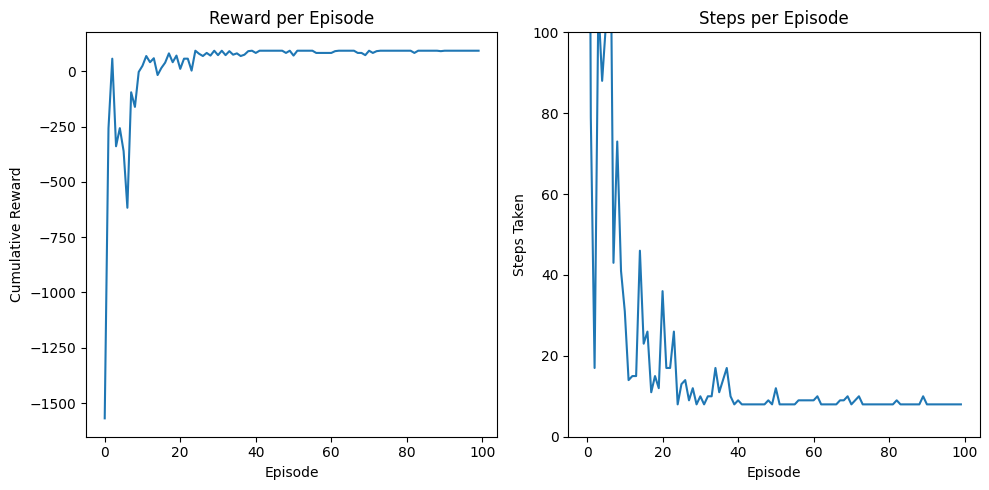

In [22]:
agent = QLearningAgent(maze)
# Training the agent
train_agent(agent, maze, num_episodes=100)

Learned Path:
(0, 0)-> (0, 0)-> (0, 1)-> (0, 2)-> (1, 2)-> (2, 2)-> (2, 3)-> (2, 4)-> (3, 4)-> Goal!
Number of steps: 8
Total reward: 93


<Figure size 640x480 with 0 Axes>

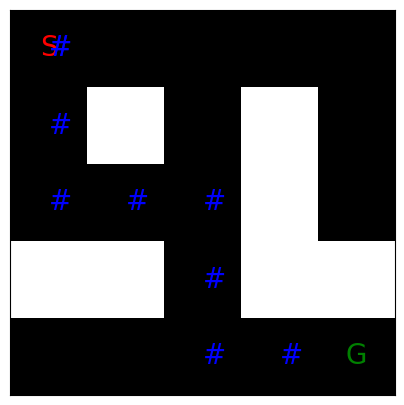

(8, 93)

In [23]:
# Testing the agent after training
test_agent(agent, maze, num_episodes=100)